<a href="https://colab.research.google.com/github/marcusborela/Aprendizado-Profundo-Unicamp/blob/main/deepLearningSentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mines and tailings dams dicovery and classification

This script is part of a research project published on the paper "Mining and Tailings Dam Detection In Satellite Imagery Using Deep Learning" by Remis Balaniuk, Olga Isupova and Steven Reece. This project was developed at the University of Oxford from September 2019 to February 2020.
It was prepared to be used on the Google Colaboratory platform (see https://colab.research.google.com/notebooks/welcome.ipynb ).  



Use GPU acceleration (Runtime >> Change runtime type) !!

Initial settings: import libraries and mount Google drive

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install rasterio
!pip install gputil
!pip install psutil
!pip install humanize
!pip install simplekml
import simplekml
import psutil
import humanize
import GPUtil as GPU
import rasterio

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import gc
import glob
import pickle as pi
import re
import math
from random import shuffle
import gdal
import os
from tempfile import NamedTemporaryFile
import h5py
import sys
from tqdm import tqdm
import itertools
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from google.colab import drive
from IPython.display import IFrame


drive.mount('/content/drive/')

%matplotlib inline

rseed = 100
np.random.seed(rseed)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=ba6fab6eb83530833adca6642e0d179c0168e76ea5823d03d030e3b2a168d81a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65876 sha256=6c82f71c18051f90dc

## Define environment for I/O:

This script assumes that the user created on his google drive (mounted as /content/drive/My Drive/) a folder named "DataForTailingDamDetection/".

Inside this folder three subfoders willl be used: Data/, Experiments/ and Results/. The first one should be used to store images for training, testing and predicting, uploaded by the user. The second will be used to store the trained models and the last one will keep predicting results. 

The analytical approach is organized in "experiments". Each experiment can have its own dataset, model and results. An experiment will have its own subfoder on each of the three main folders: Data/, Experiments/ and Results/. 

For each new experiment the user must create a new subfolder under the folder  Data/ named after his experiment. Inside this Data/\<experiment name\>/ folder the user will create two subfolders: train/ and predict/. The train/ folder must be used to put all training and testing images. The images must be organized in subfolders, with one subfolder for each class. On Data/\<experiment name\>/predict/ the user will store the large satellite images for which predicting will be done.

The remaining folders will be created automatically by the script.

Two experiments were described on the paper  "Mining and Tailings Dam Detection In Satellite Imagery Using Deep Learning". The first implements mines and tailings dams discovery and the second classifies the ore type of discovery mines and tailings dams. This is the folder's tree for the project experiments:

![](https://drive.google.com/file/d/1GdqNvfEzfb5JCG7YYirThg9aUHl8TM26/view?usp=sharing)

In [2]:
 %cd /content/drive/My Drive/

# root folder for the project data
path_ref = './curso_analise_imagens_satelite/FinalLixoes/'
sys.path.extend([path_ref])

data_path = 'Data/'
exp_names = []

#-----------------------------------------------
# user definitions
MINE_IMAGE_WIDTH = 40 # 400 x 400
MINE_IMAGE_HEIGHT = 40
#ORE_IMAGE_WIDTH = 21
#ORE_IMAGE_HEIGHT = 21
N_BANDS = 7
# names of the image folders
experiment_name = ''  
# oretypeclassifier = 'SentinelOreType' # set to None if ore classifier is not required
#-----------------------------------------------

experiments_path = 'Experiments/'
result_path = 'Results/'
if not os.path.exists(path_ref + experiments_path):
    os.makedirs(path_ref + experiments_path)
if not os.path.exists(path_ref + result_path):
    os.makedirs(path_ref + result_path)

train_data = 'train/'   
predict_data =  'predict/' 

# user must create the train_data folder and put the training images on subfolders (one per class)
path_to_images = path_ref + data_path + experiment_name + '/' + train_data 
#path_to_oretype_samples = path_ref + data_path + oretypeclassifier + '/' + train_data 

# if user wants to use model to predict on large images he must create the predict folder and put the images 
path_to_predict_images = path_ref + data_path + experiment_name + '/' + predict_data

# will save training results here
path_to_output = path_ref + experiments_path + experiment_name + '/'
# path_to_oretype_output = path_ref + experiments_path + oretypeclassifier + '/'

#will save prediction results here
path_to_results = path_ref + result_path + experiment_name + '/'
if not os.path.exists(path_to_results):
    os.makedirs(path_to_results)
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

/content/drive/My Drive


Before following this script make sure that the images for training were uploaded to the "path_to_images" folder. For each class define a subfoder to store its images. To obtain the images on Google Earth Engine use the loadminetailingsdam.ipynb notebook.

In [12]:
%cd "content/drive"

[Errno 2] No such file or directory: 'content/drive'
/content/drive/My Drive


In [13]:
%ls

 1_4911225524505804922.epub
 A_converter/
'Auto Call Recorder'/
'Cartão de embarque | LATAM Airlines no Brasil.pdf'
 Classroom/
'Colab Notebooks'/
 coordenadas_lixoeslixao100.tif
 coordenadas_lixoeslixao101.tif
 coordenadas_lixoeslixao102.tif
 coordenadas_lixoeslixao103.tif
 coordenadas_lixoeslixao104.tif
 coordenadas_lixoeslixao105.tif
 coordenadas_lixoeslixao106.tif
 coordenadas_lixoeslixao107.tif
 coordenadas_lixoeslixao108.tif
 coordenadas_lixoeslixao109.tif
 coordenadas_lixoeslixao110.tif
 coordenadas_lixoeslixao111.tif
 coordenadas_lixoeslixao112.tif
 coordenadas_lixoeslixao113.tif
 coordenadas_lixoeslixao114.tif
 coordenadas_lixoeslixao115.tif
 coordenadas_lixoeslixao116.tif
 coordenadas_lixoeslixao117.tif
 coordenadas_lixoeslixao118.tif
 coordenadas_lixoeslixao119.tif
 coordenadas_lixoeslixao120.tif
 coordenadas_lixoeslixao121.tif
 coordenadas_lixoeslixao122.tif
 coordenadas_lixoeslixao123.tif
 coordenadas_lixoeslixao124.tif
 coordenadas_lixoeslixao125.tif
 coordenadas_lixoesl

In [14]:
%mv coordenadas_lixoes*.tif curso_analise_imagens_satelite/FinalLixoes/Data/train/lixao

## Declaring functions

In [5]:
global n_classes

def custom_sparse_categorical_accuracy(y_true,y_pred):
  sh=tf.shape(y_pred)
  y_pred = tf.reshape(y_pred, [sh[0]*sh[1],n_classes])   # adjust the last argument for the number of classes 
  y_true = tf.reshape(y_true, [sh[0]*sh[1],1])
  
  return tf.keras.metrics.sparse_categorical_accuracy(y_true,y_pred)

def custom_sparse_categorical_crossentropy(y_true,y_pred):
  sh=tf.shape(y_pred)
  y_pred = tf.reshape(y_pred, [sh[0]*sh[1],n_classes]) # adjust the last argument for the number of classes 
  y_true = tf.reshape(y_true, [sh[0]*sh[1],1])
 
  return tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)

def count_images(path_to_samples):
  n_images = 0
  print(path_to_samples)
  minpf = None
  cd = 0
  for label_num, subdir in enumerate(next(os.walk(path_to_samples))[1]):
    x = len(os.listdir(path_to_samples + subdir))
    print("dir:",path_to_samples + subdir,x)
    n_images += x
    cd += 1
    if minpf is None or x<minpf:
      minpf=x

  return n_images,minpf,cd


In [6]:
def load_images_as_training_data(path_to_samples,experiment_type):

  if experiment_type==0:
    image_width = MINE_IMAGE_WIDTH
    image_height = MINE_IMAGE_HEIGHT
  else:
    image_width = ORE_IMAGE_WIDTH
    image_height = ORE_IMAGE_HEIGHT

  Nbands = N_BANDS

  # this script assumes that Sentinel 2 12 spectral bands images are being used
  # opt_string = '-outsize {} {} -b 1 -b 2 -b 3 -b 4 -b 5 -b 6 -b 7 -b 8 -b 9 -b 10 -b 11 -b 12'.format(image_height, image_width)
  opt_string = '-outsize {} {} -b 1 -b 2 -b 3 -b 4 -b 5 -b 6 -b 7'.format(image_height, image_width)
  qtd_images,min_per_folder,dirs = count_images(path_to_samples)

  # loads the same number of images from each folder
  print("Will load {} images from each folder.".format(min_per_folder))
  n_images = min_per_folder*dirs

  image = np.zeros((n_images, image_width, image_height, Nbands), dtype=np.float32)
  label = -1 * np.ones((n_images,), dtype=np.int64)
  char_labels = []

  image_counter = 0
  for label_num, subdir in enumerate(next(os.walk(path_to_samples))[1]):
    char_labels.append(subdir)

    print("Loading images for class",path_to_samples + subdir)

    files = np.array(os.listdir(path_to_samples + subdir))
    permutation = np.random.permutation(len(files))
    files = files[permutation]
    count_this_folder = 0
    for file in files:
        img_dataset = gdal.Translate(NamedTemporaryFile(delete=False).name,
                                     gdal.Open(path_to_samples + subdir + '/' + file, gdal.GA_ReadOnly),
                                     options=opt_string)

        img_array = np.transpose(np.array(img_dataset.ReadAsArray(),dtype = 'float32'), axes=(1, 2, 0))

        image[image_counter, :, :, :] = img_array[:,:,0:Nbands]
        label[image_counter] = label_num
        image_counter += 1
        count_this_folder +=1
        if count_this_folder>=min_per_folder:   # keeping the same number of samples for all classes
          break

  return n_images,image,label,char_labels,image_width,image_height,Nbands,experiment_type
    

In [7]:
def save_training_data_to_file(path_to_model,image,label,charlabel,image_width,image_height,nmean,nmax,Nbands,n_classes,experiment_type):
  print("Saving data:",charlabel,path_to_model)
  np.savez(path_to_model + 'trainingData',
             images=image,
             labels=label,
             charlabels = charlabel)
  
  np.savez(path_to_model + 'modelMetaData',
             metadata =np.array([image_width,image_height,Nbands,n_classes,charlabel,experiment_type])) 

  save_normal_std(path_to_model,nmean,nmax)
  
def load_training_data_from_file(path_to_model):
  npzfile = np.load(path_to_model + 'trainingData.npz')
  image = npzfile['images']
  label = npzfile['labels']
  charlabel = npzfile['charlabels']
 
  n_images = image.shape[0]
  metadata = np.load(path_to_model + 'modelMetaData.npz',allow_pickle=True)
  image_width,image_height,n_bands,n_classes,char_labels,experiment_type = metadata['metadata'] 

  # training data was saved already normalized
  nmean,nmax = load_normal_std(path_to_model)

  return image,label,charlabel,n_images,image_width,image_height,n_bands,nmean,nmax,experiment_type


In [8]:
def normalize_data(path_to_model,image,Nbands,nmean,nmax,save = True,loadfrom = None):
  
  given = True
  if nmean is None:
    if loadfrom is not None:
      nmean,nmax = load_normal_std(loadfrom)
    else:
      nmean = np.zeros(Nbands)
      nmax = np.zeros(Nbands)
      given = False

  # Normalize pixel values to be between 0 and 1
  for i in range(Nbands):
    if not given:
      nmean[i] = np.mean(image[:,:,:,i])
      nmax[i] = np.std(image[:,:,:,i])
    image[:,:,:,i]=image[:,:,:,i]-nmean[i]
    image[:,:,:,i]=image[:,:,:,i]/nmax[i]

  if save:
    save_normal_std(path_to_model,nmean,nmax)

  return image,nmean,nmax

def save_normal_std(path_to_model,nmean,nmax):
  np.savez(path_to_model + 'trainingDataAvgStd',
             median=nmean,
             std=nmax)
  
def load_normal_std(path_to_model):
  npzfile = np.load(path_to_model + 'trainingDataAvgStd.npz',)
  nmean = npzfile['median']
  nmax = npzfile['std']

  return nmean,nmax



In [9]:
def convert_label_to_one_hot(labels, n_classes):
    labels_arr = np.atleast_1d(labels)  # in case labels is a scalar
    one_hot_labels = np.zeros((labels_arr.shape[0], n_classes), dtype = np.int)
    one_hot_labels[np.arange(labels_arr.shape[0]), labels_arr] = 1
    return one_hot_labels

def split_training_test_sets(image,label,split_ratio):
  # split_ratio defines the training share of the data. Must be between 0 and 1.

  n_images,image_width,image_height,Nbands = image.shape

  permutation = np.random.permutation(n_images)
  image = image[permutation]
  label = label[permutation]

  Ntrain = int(n_images*split_ratio)
  max_Ntrain = n_images

  ls = list(label.shape)

  ls[0]=Ntrain
  train_images = np.zeros((Ntrain,image_width,image_height,Nbands))
  train_labels = np.zeros(tuple(ls)) # (Ntrain,))

  ls[0]=max_Ntrain - Ntrain
  test_images = np.zeros((max_Ntrain - Ntrain,image_width,image_height,Nbands))
  test_labels = np.zeros(tuple(ls)) #(max_Ntrain - Ntrain,))

  train_images[:Ntrain] = image[:Ntrain] 
  train_labels[:Ntrain] = label[:Ntrain] 

  test_images[:] = image[Ntrain:]
  test_labels[:] = label[Ntrain:]

  return train_images,train_labels,test_images,test_labels


In [18]:
import keras

In [24]:
def define_FCN_discovery(image_width,image_height,nc,Nbands):

  global n_classes
  n_classes = nc
  kx = math.ceil((image_width-32)/27)  
  ky = math.ceil((image_height-32)/27)  
  # define the Fully Convolution Neural Network

  data_augmentation = keras.Sequential(
      [
          layers.experimental.preprocessing.RandomFlip("horizontal"),
          layers.experimental.preprocessing.RandomRotation(0.1),
          layers.experimental.preprocessing.RandomZoom(0.2),
      ]
  )

  input=layers.Input(shape=(None, None, Nbands))
  x=data_augmentation(input)
  x0=layers.Conv2D(32, (3, 3), (1,1), activation='relu', padding='SAME')(x)
  x1=layers.MaxPooling2D((3, 3))(x0)
  x2=layers.Conv2D(64, (3, 3), (1,1), activation='relu', padding='SAME')(x1)
  x3=layers.MaxPooling2D((3, 3))(x2)
  x4=layers.Conv2D(64, (3, 3), (1,1), activation='relu', padding='SAME')(x3)
  x5=layers.MaxPooling2D((3,3))(x4)
  x6=layers.Conv2D(64, (kx,ky), (1,1), activation = 'relu')(x5)  # the convolution kernel size must be adapted for image size 
  x7=layers.Dropout(0.5)(x6)
  x8=layers.Conv2D(n_classes, (1,1), (1,1), padding='VALID', activation='softmax')(x7)
  model=models.Model(input,x8)
  model.summary()

  model.compile(optimizer='adam',
              loss=custom_sparse_categorical_crossentropy,
              metrics=[custom_sparse_categorical_accuracy])
             
  return model


In [25]:
def tf_cross_entropy_with_logits(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

"""
def define_FCN_oretype(image_width,image_height,nc,Nbands):

  global n_classes
  n_classes = nc
  
  input_shape=(image_width, image_height, Nbands)
  print(input_shape)
  cnn_model = tf.keras.models.Sequential()
  cnn_model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
  cnn_model.add(tf.keras.layers.Conv2D(32, (2, 2), strides=1, padding='same'))
  cnn_model.add(tf.keras.layers.Activation('relu'))
  cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
  cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=1, padding='same'))
  cnn_model.add(tf.keras.layers.Activation('relu'))
  cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
  cnn_model.add(tf.keras.layers.Flatten())
  cnn_model.add(tf.keras.layers.Dense(1024))
  cnn_model.add(tf.keras.layers.Activation('relu'))
  cnn_model.add(tf.keras.layers.Dropout(0.5))
  cnn_model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
  cnn_model.summary()

  adam = tf.keras.optimizers.Adam(lr=1e-4)

  cnn_model.compile(optimizer=adam, loss=tf_cross_entropy_with_logits, metrics=['accuracy'])

  return cnn_model
"""             

def fit_model(path_to_model,model, train_images, train_labels, epochs = 20, batchsize = 16, plot_accuracy = True, save_model = True):

  # Create a callback that saves the model's weights
  if save_model:

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= path_to_model + 'trained_model/weights.ckpt',
                                                    save_weights_only=True,
                                                    verbose=1)

    fit = model.fit(train_images, train_labels, epochs=epochs, batch_size=batchsize,callbacks=[cp_callback])
  else:
    fit = model.fit(train_images, train_labels, epochs=epochs, batch_size=batchsize)

  accuracy = fit.history[list(fit.history.keys())[-1]]

  if plot_accuracy:
    plt.plot(range(epochs), accuracy, 'r--', label='train')
    plt.title('Training accuracy')
    plt.show()

  return model,accuracy

def custom_fit(path_to_model,model_type, image, label,image_width,image_height,n_classes,Nbands,batchsize = 16, plot_accuracy = True, save_model = True):

  print("How many folds for cross validation? ")
  try:
    n_cv_runs=int(input('Input:'))
  except ValueError:
    print("Not a number")

  print("How many epochs at each fold ? ")
  try:
    n_epoch=int(input('Input:'))
  except ValueError:
    print("Not a number")

  bestaccuracy = -1
  accuracyTrain = np.zeros((n_cv_runs,n_epoch))
  accuracyTest = np.zeros((n_cv_runs,n_epoch))
  f1Score= np.zeros((n_cv_runs,n_epoch))
  confusionMatrix = np.zeros((n_cv_runs,n_epoch,n_classes,n_classes))
  precision = np.zeros(n_cv_runs)
  recall = np.zeros(n_cv_runs)
  roc_auc = np.zeros(n_cv_runs)
  matthews = np.zeros(n_cv_runs)
  kappa = np.zeros(n_cv_runs)

  models = []
  # define model and compile
  if model_type==0:
    model = define_FCN_discovery(image_width,image_height,n_classes,Nbands)
  else:
    model = define_FCN_oretype(image_width,image_height,n_classes,Nbands)
  # save initial state
  weights = model.get_weights() 

  # shuffle image set
  permutation = np.random.permutation(len(image))
  image = image[permutation]
  label = label[permutation]

  kf = KFold(n_splits=n_cv_runs)
 
  cv_run = 0
  for train_idx, val_idx in kf.split(image,label):
    train_images = image[train_idx]
    train_labels = label[train_idx]
    test_images = image[val_idx]
    test_labels = label[val_idx]

    print('\tfold %d...' % cv_run)

    for epoch in range(n_epoch):
      print('\tepoch %d...' % epoch)

      fit = model.fit(train_images, train_labels, epochs=1, batch_size=batchsize)
      
      accuracyTrain[cv_run,epoch] = fit.history[list(fit.history.keys())[-1]][-1]

      # testing
      prediction = model.predict(test_images)
      predics = np.zeros(len(prediction))
      if model_type==0:
        predics = prediction[:,0,0,:].argmax(axis=1) 
        tl = test_labels 
      else:
        predics = prediction[:,:].argmax(axis=1) 
        tl = test_labels.argmax(axis=1)

      # metrics
      accuracyTest[cv_run,epoch] = accuracy_score(tl, predics)
      if n_classes == 2:
        f1Score[cv_run,epoch]  = f1_score(tl, predics)
      confusionMatrix[cv_run,epoch] = confusion_matrix(tl, predics)
      
    print("Final metrics on fold",cv_run,": accuracy on training:",accuracyTrain[cv_run,-1],"accuracy on testing:",accuracyTest[cv_run,-1])
    if n_classes == 2:
      print("F1 score:",f1Score[cv_run,-1])
      show_metrics_sklearn(tl, predics)
    print("Confusion matrix:",confusionMatrix[cv_run,-1])
    
    if n_classes == 2:
      precision[cv_run] = metrics.precision_score(tl, predics)
      recall[cv_run] = metrics.recall_score(tl, predics)
      roc_auc[cv_run] = metrics.roc_auc_score(tl, predics)

    matthews[cv_run] = metrics.matthews_corrcoef(tl, predics)
    kappa[cv_run] = metrics.cohen_kappa_score(tl, predics)

    plt.plot(range(n_epoch), accuracyTrain[cv_run], 'r--', label='train')
    plt.plot(range(n_epoch), accuracyTest[cv_run], 'b-', label='test')
    plt.title('Accuracy {} run'.format(cv_run))
    plt.savefig(path_to_model + 'accuracy_results_{}.pdf'.format(cv_run))
    plt.show()

    model.save(path_to_model + 'trained_model/weights_{}_run.ckpt'.format(cv_run))
 
    np.savez(path_to_model + 'results_{}_run'.format(cv_run),
              train_accuracy=accuracyTrain[cv_run],
              f1Score=f1Score[cv_run],
              test_accuracy=accuracyTest[cv_run],
              confusionMatrix=confusionMatrix[cv_run],
              precision = precision[cv_run],
              recall = recall[cv_run],
              roc_auc = roc_auc[cv_run],
              matthews = matthews[cv_run],
              kappa = kappa[cv_run])
    
    # return model to initial state
    model.set_weights(weights)
    del train_images,train_labels,test_images,test_labels
    gc.collect()
    cv_run+=1

  print("Summary:")
  for cv_run in range(n_cv_runs):
    plt.plot(range(n_epoch), accuracyTrain[cv_run], 'r--', label='train{}_run'.format(cv_run))
    plt.plot(range(n_epoch), accuracyTest[cv_run], 'b-', label='test{}_run'.format(cv_run))
    print("Fold",cv_run,": accuracy on training:",accuracyTrain[cv_run,-1],"accuracy on testing:",accuracyTest[cv_run,-1],"F1 score:",f1Score[cv_run,-1])

  plt.title('Accuracy final')
  plt.savefig(path_to_model + 'accuracy_results_final.pdf')
  plt.show()

  print("Which model do you want to use?")
  try:
    id=int(input('Input:'))
  except ValueError:
    print("Not a number")

  np.savez(path_to_model + 'results_final',
              train_accuracy=accuracyTrain,
              f1Score=f1Score,
              test_accuracy=accuracyTest,
              confusionMatrix=confusionMatrix,
              precision = precision,
              recall = recall,
              roc_auc = roc_auc,
              matthews = matthews,
              kappa = kappa,
              chosen = id)

  # load the chosen model from disk
  model.load_weights(path_to_model + 'trained_model/weights_{}_run.ckpt/variables/variables'.format(id))

  return model

def show_model_metrics(path_to_model):
  npzfile = np.load(path_to_model + 'results_final.npz')
          
  train_accuracy = npzfile['train_accuracy']
  f1Score = npzfile['f1Score']
  test_accuracy = npzfile['test_accuracy']
  confusionMatrix = npzfile['confusionMatrix']
  precision = npzfile['precision']
  recall = npzfile['recall']
  roc_auc = npzfile['roc_auc']
  matthews = npzfile['matthews']
  kappa = npzfile['kappa']
  chosen = npzfile['chosen']
 
  print("train acc:",train_accuracy[:,-1])
  print("train acc:",test_accuracy[:,-1])
  folds = train_accuracy.shape[0]
  epochs = train_accuracy.shape[1]
  print("Average metrics for the last epoch of {} folds:".format(folds))
  print('train_accuracy:',train_accuracy[:,-1].mean())
  print('train_accuracy std:',train_accuracy[:,-1].std())
  print('train_accuracy range:',train_accuracy[:,-1].ptp())
  print('train_accuracy % range:',train_accuracy[:,-1].ptp()/2*train_accuracy[:,-1].mean())
  print('test_accuracy:',test_accuracy[:,-1].mean()) 
  print('test_accuracy std:',test_accuracy[:,-1].std()) 
  print('test_accuracy range:',test_accuracy[:,-1].ptp()) 
  print('test_accuracy % range:',test_accuracy[:,-1].ptp()/2*test_accuracy[:,-1].mean()) 
  print('f1Score:',f1Score[:,-1].mean())  
  print('confusionMatrix:',confusionMatrix[:,-1,:,:].mean(axis=0))
  print('precision:',precision.mean())
  print('recall:',recall.mean())
  print('roc_auc:',roc_auc.mean())
  print('matthews:',matthews.mean())
  print('kappa:',kappa.mean())


  print("Metrics for the chosen model:")
  print('train_accuracy:',train_accuracy[chosen,-1])
  print('test_accuracy:',test_accuracy[chosen,-1]) 
  print('f1Score:',f1Score[chosen,-1])  
  print('confusionMatrix:',confusionMatrix[chosen,-1,:,:])
  print('precision:',precision[chosen])
  print('recall:',recall[chosen])
  print('roc_auc:',roc_auc[chosen])
  print('matthews:',matthews[chosen])
  print('kappa:',kappa[chosen])

  IFrame(path_to_model + 'accuracy_results_final.pdf', width=600, height=300)

  
def load_weights(path_to_model,model):
    
  if os.path.exists(path_to_model + 'trained_model/checkpoint'): 
    print("Single trained model found. Do you want to load it? (1:yes/0:no)" )
    try:
      resp=int(input('Input:'))
    except ValueError:
      print("Not a number")
    if resp==1:
      model.load_weights(path_to_model + 'trained_model/weights.ckpt')
      return model

  if os.path.exists(path_to_model + 'results_final.npz'): # check if there is k-fold saved models available
    results = np.load(path_to_model + 'results_final.npz')
    print("K-fold cross validation trained models found:")
    for i in range(0,len(results['train_accuracy'])):
      print('Model {}: train accuracy = {} test accuracy = {} f1 score = {}'.format(i,results['train_accuracy'][i,-1],results['test_accuracy'][i,-1],results['f1Score'][i,-1]))
    print("Which one do you want to load?" )
    try:
      resp=int(input('Input:'))
    except ValueError:
      print("Not a number")
    if resp < 0 or resp>len(results['train_accuracy']):
      raise Exception("Invalid model choice")

    model.load_weights(path_to_model + 'trained_model/weights_{}_run.ckpt/variables/variables'.format(resp))

    return model

  raise Exception("No model loaded")

def load_model(path_to_model):
  
  metadata = np.load(path_to_model + 'modelMetaData.npz',allow_pickle=True)
  image_width,image_height,n_bands,n_classes,char_labels,experiment_type = metadata['metadata'] 

  if experiment_type==0:  # dams discovery  
    model = define_FCN_discovery(image_width,image_height,n_classes,n_bands)
  else:
    model = define_FCN_oretype(image_width,image_height,n_classes,n_bands)

  model= load_weights(path_to_model,model)
  nmean,nmax = load_normal_std(path_to_model)
  
  return model,image_width,image_height,n_bands,n_classes,nmean,nmax,char_labels,experiment_type

def train_test(path_to_model,model_type,image,label,image_width,image_height,n_classes,Nbands,clearMemory = True):

  if model_type==1:  # not a FCN
    label = convert_label_to_one_hot(label,n_classes)

  print("Training and testing (0.8 - 0.2 split):1, training for predicting (no split, no testing): 2 or customized learning : 3 ? ((1/2/3))")
  try:
    r=int(input('Input:'))
  except ValueError:
    print("Not a number")

  if r==3:
    model = custom_fit(path_to_model,model_type, image,label,image_width,image_height,n_classes,Nbands)
  else:
    if model_type==0:
      model = define_FCN_discovery(image_width,image_height,n_classes,Nbands)
    else:
      model = define_FCN_oretype(image_width,image_height,n_classes,Nbands)

    if r == 1:
      train_images,train_labels,test_images,test_labels = split_training_test_sets(image,label,0.8)
      model,accuracy = fit_model(path_to_model,model, train_images, train_labels)
      # testing
      print("Testing:")
      prediction = model.predict(test_images)
      
      predics = np.zeros(len(prediction))
      if model_type==0:
        predics = prediction[:,0,0,:].argmax(axis=1) 
      else:
        predics = prediction[:,:].argmax(axis=1)
        test_labels = test_labels[:,:].argmax(axis=1)

      print(confusion_matrix(test_labels, predics))
      if n_classes==2:
        show_metrics_sklearn(test_labels, predics)
      
      del test_images
      del test_labels
      del train_images
      del train_labels
    else: 
      model,accuracy = fit_model(path_to_model,model, image,label)
      print("Final accuracy:",accuracy[-1])

  if clearMemory:
    del image
    del label
    
  gc.collect()

  return model

def predict(main_model,ore_classifier,n_images,main_labels,ore_labels,image_width,image_height,nmean,nmax,Nbands,slicing = 1):

  countImages = 0
  
  print("Choose target class: ")
  for i in range(0, len(main_labels)):
    print(i,":",main_labels[i])
  try:
    save=int(input('Input:'))
  except ValueError:
    print("Not a number")

  print("Choose the no ore class: ")
  for i in range(0, len(ore_labels)):
    print(i,":",ore_labels[i])
  try:
    noore=int(input('Input:'))
  except ValueError:
    print("Not a number")

  kmlFull=simplekml.Kml()
  resultsFull = [] 

  # process each image on the predict folder
  for file in os.listdir(path_to_predict_images):
    print(file)
    starthere = len(resultsFull)

    testimage = gdal.Translate(NamedTemporaryFile(delete=False).name,
                                  gdal.Open(path_to_predict_images + file, gdal.GA_ReadOnly),
                                  options = '-b 1 -b 2 -b 3 -b 4 -b 5 -b 6 -b 7 -b 8 -b 9 -b 10 -b 11 -b 12')

    testimage = np.transpose(np.array(testimage.ReadAsArray(),dtype = 'float32'), axes=(1, 2, 0))
    testimage = testimage[:,:,0:Nbands]
    for i in range(Nbands):
      testimage[:,:,i]=testimage[:,:,i]-nmean[i]
      testimage[:,:,i]=testimage[:,:,i]/nmax[i]

    # slice the image for prediction if it is to too large for colab. 
    # Divides the image and regular 2D patches
    # Adapt the "slicing" for your size of image and colab memory availability:  
    
    sh = np.array(testimage.shape)
    sh[0] = sh[0]//slicing
    sh[1] = sh[1]//slicing
    prediction = None
    for i in range(0,slicing):  
      for j in range(0,slicing):
        patch = np.expand_dims(testimage[sh[0]*i:sh[0]*(i+1),sh[1]*j:sh[1]*(j+1),:],axis=0) 
        # compute prediction of the FCN
        if prediction is None:
          prediction = main_model.predict(patch)
        else:
          prediction = np.append(prediction,main_model.predict(patch), axis=0)
      
    # locate the predictions on the patches

    shp = prediction.shape
    results = []
    lpatches = []
    kml=simplekml.Kml()
    count_positives = 0

    with rasterio.open(path_to_predict_images+file) as map_layer:
      for i in range(0,slicing):  
        for j in range(0,slicing): 
 
          pos = i*slicing+j
          
          pred_classes = tf.greater(prediction[pos,:,:,save],0.6) # considering a 60% probability threshold to accept a positive
          shpc = tf.shape(pred_classes)

          inds = tf.where(pred_classes==True)

          # Upsampling to original image dimensions.
          
          xloc = i*sh[0]+np.array(tf.gather(np.linspace(image_width/2.0,sh[0]-image_width/2.0,num=shpc[0]),inds[:,0]))
          yloc = j*sh[1]+np.array(tf.gather(np.linspace(image_height/2.0,sh[1]-image_height/2.0,num=shpc[1]),inds[:,1]))
          predloc = prediction[pos,inds[:,0],inds[:,1],save]

          for k in range(0,len(xloc)):
            pixels2coords = map_layer.xy(xloc[k] , yloc[k]) 

            r = np.ones(4)*-1      
            
            r[0] = pixels2coords[0]
            r[1] = pixels2coords[1]
            r[2] = predloc[k]

            # prepare ore type prediction
            if ore_classifier is not None: 
              #lx = int(round(xloc[k]-(ORE_IMAGE_WIDTH)))
              lx = int(round(xloc[k]-(ORE_IMAGE_WIDTH//2)))
              if lx<0:
                lx=0
              #ly = int(round(yloc[k]-(ORE_IMAGE_HEIGHT)))
              ly = int(round(yloc[k]-(ORE_IMAGE_HEIGHT//2)))
              if ly<0:
                ly=0
              hx = lx+ORE_IMAGE_WIDTH
              if hx>testimage.shape[0]:
                hx=testimage.shape[0]
              
              hy = ly+ORE_IMAGE_HEIGHT
              if hy>testimage.shape[1]:
                hy=testimage.shape[1]
              
              lpatch = np.expand_dims(testimage[lx:hx,ly:hy,:],axis=0)  
              ore_prediction = ore_classifier.predict(lpatch)
              
              # ore type winner
              r[-1] = ore_prediction[0,:].argmax()
              tag = ore_labels[r[-1].astype(int)]
            else:
              tag = main_labels[save]
              
            if r[-1] != noore: # if no ore was detected discard point
              kml.newpoint(name=tag, coords=[(pixels2coords[0],pixels2coords[1])])
              kmlFull.newpoint(name=tag, coords=[(pixels2coords[0],pixels2coords[1])])

              results.append(r)
              resultsFull.append(r)

    # save prediction files to the results folder
    np.savetxt(path_to_results + 'prediction_{}.csv'.format(file), results, delimiter=",")
    kml.save(path_to_results + 'predictions_{}.kml'.format(file))  

    countImages+=1

    del testimage
    del patch
    del prediction
    del results
    del kml
    gc.collect()

    if n_images != -1 and countImages>=n_images:
      break

  np.savetxt(path_to_results + 'prediction_{}.csv'.format(experiment_name), np.array(resultsFull), delimiter=",")
  kmlFull.save(path_to_results + 'predictions_{}.kml'.format(experiment_name))  


In [ ]:
def model_workflow(path_to_model, path_to_images, model_type,main_model = None,nmean=None,nmax=None):

  load = False
  if os.path.exists(path_to_model + 'trained_model/checkpoint') or os.path.exists(path_to_model + 'results_final.npz'): # check if there is a saved model available
    print("Saved model found. Do you want to load it? ((1:yes/0:no))")
    try:
      r=int(input('Input:'))
    except ValueError:
      print("Not a number")
    if r == 1:
      model,image_width,image_height,Nbands,n_classes,nmean,nmax,char_labels,experiment_type = load_model(path_to_model)
      load = True

  if not load:  # training new model
    # load training data from images or from array
    loaded = False
    if os.path.exists(path_to_model + 'trainingData.npz'):
      print("Saved training data found. Do you want to load it? ((1:yes/0:no))")
      try:
        r=int(input('Input:'))
      except ValueError:
        print("Not a number")
      if r == 1:
        # loading data from array already normalized
        image,label,char_labels,n_images,image_width,image_height,Nbands,nmean,nmax,experiment_type = load_training_data_from_file(path_to_model)
        loaded = True

    if not loaded: # load data from images and normalize

      n_images,image,label,char_labels,image_width,image_height,Nbands,experiment_type = load_images_as_training_data(path_to_images,model_type)
      image,nmean,nmax =  normalize_data(path_to_model,image,Nbands,nmean,nmax)

      print("Training data loaded from the image sets:",n_images,char_labels)
      print("Do you want to save images as arrays for faster future loading? ((1:yes/0:no))")
      try:
        r=int(input('Input:'))
      except ValueError:
        print("Not a number")
      if r == 1:
        save_training_data_to_file(path_to_model,image,label,char_labels,image_width,image_height,nmean,nmax,Nbands,len(char_labels),model_type) # saving normalized data

    n_classes = len(char_labels)
    print("Training data loaded:",image_width,image_height,Nbands,n_classes,char_labels,np.isnan(np.sum(image)))
    model = train_test(path_to_model, model_type,image,label,image_width,image_height,n_classes,Nbands)

  return model,char_labels,image_width,image_height,nmean,nmax

def show_metrics_sklearn(y_true, y_pred):
  print("Precision: ", metrics.precision_score(y_true, y_pred))
  print("Recall: ", metrics.recall_score(y_true, y_pred))
  print("F1 score: ", metrics.f1_score(y_true, y_pred))
  print("Mean accuracy: ", metrics.accuracy_score(y_true, y_pred))
  print("AUC: ", metrics.roc_auc_score(y_true, y_pred))
  print("mcc: ", metrics.matthews_corrcoef(y_true, y_pred))
  print("kappa: ", metrics.cohen_kappa_score(y_true, y_pred))


## Main workflow:

The following script was used to implement the method described on the paper "Mining and Tailings Dam Detection In Satellite Imagery Using Deep Learning". It trains a first CNN to identify surface mines on satellite images and a second CNN to classify the potential environment impact of the discovered mining spots. If trained models are detected on the "Experiments" folder the user can choose to load them instead of retrain new models. Trained or loaded models can then be used to discover and classify mines on large areas represented by satellite images contained  "predict" folder. Results are recorded on files made available on the "Results" folder.

Discovery model:
Saved model found. Do you want to load it? ((1:yes/0:no))
Input:0
Saved training data found. Do you want to load it? ((1:yes/0:no))
Input:0
./curso_analise_imagens_satelite/FinalLixoes/Data//train/
dir: ./curso_analise_imagens_satelite/FinalLixoes/Data//train/lixao 270
dir: ./curso_analise_imagens_satelite/FinalLixoes/Data//train/naolixao 176
Will load 176 images from each folder.
Loading images for class ./curso_analise_imagens_satelite/FinalLixoes/Data//train/lixao
Loading images for class ./curso_analise_imagens_satelite/FinalLixoes/Data//train/naolixao
Training data loaded from the image sets: 352 ['lixao', 'naolixao']
Do you want to save images as arrays for faster future loading? ((1:yes/0:no))
Input:1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


Saving data: ['lixao', 'naolixao'] ./curso_analise_imagens_satelite/FinalLixoes/Experiments//
Training data loaded: 40 40 7 2 ['lixao', 'naolixao'] True
Training and testing (0.8 - 0.2 split):1, training for predicting (no split, no testing): 2 or customized learning : 3 ? ((1/2/3))
Input:1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 7)]   0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, 7)     0         
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 32)    2048      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                               

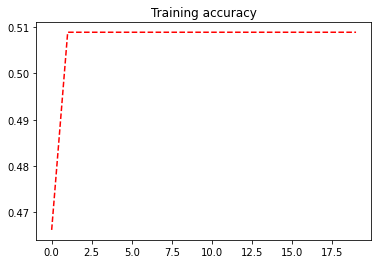

Testing:
[[33  0]
 [38  0]]
Precision:  0.0
Recall:  0.0
F1 score:  0.0
Mean accuracy:  0.4647887323943662
AUC:  0.5
mcc:  0.0
kappa:  0.0
['lixao', 'naolixao']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#load or train main experiment (mines an dams discovery)
print("Discovery model:")
main_model,main_labels,image_width,image_height,nmean,nmax = model_workflow(path_to_output, path_to_images, 0)
print(main_labels)

In [20]:
#load or train main experiment (mines an dams discovery)
print("Discovery model:")
main_model,main_labels,image_width,image_height,nmean,nmax = model_workflow(path_to_output, path_to_images, 0)
print(main_labels)


Discovery model:
Saved model found. Do you want to load it? ((1:yes/0:no))
Input:0
Saved training data found. Do you want to load it? ((1:yes/0:no))
Input:0
./curso_analise_imagens_satelite/FinalLixoes/Data//train/
dir: ./curso_analise_imagens_satelite/FinalLixoes/Data//train/lixao 270
dir: ./curso_analise_imagens_satelite/FinalLixoes/Data//train/naolixao 176
Will load 176 images from each folder.
Loading images for class ./curso_analise_imagens_satelite/FinalLixoes/Data//train/lixao
Loading images for class ./curso_analise_imagens_satelite/FinalLixoes/Data//train/naolixao
Training data loaded from the image sets: 352 ['lixao', 'naolixao']
Do you want to save images as arrays for faster future loading? ((1:yes/0:no))
Input:1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


Saving data: ['lixao', 'naolixao'] ./curso_analise_imagens_satelite/FinalLixoes/Experiments//
Training data loaded: 40 40 7 2 ['lixao', 'naolixao'] False
Training and testing (0.8 - 0.2 split):1, training for predicting (no split, no testing): 2 or customized learning : 3 ? ((1/2/3))
Input:1


ValueError: ignored

Discovery model:
Saved model found. Do you want to load it? ((1:yes/0:no))
Input:0
Saved training data found. Do you want to load it? ((1:yes/0:no))
Input:0
./curso_analise_imagens_satelite/FinalLixoes/Data//train/
dir: ./curso_analise_imagens_satelite/FinalLixoes/Data//train/lixao 270
dir: ./curso_analise_imagens_satelite/FinalLixoes/Data//train/naolixao 176
Will load 176 images from each folder.
Loading images for class ./curso_analise_imagens_satelite/FinalLixoes/Data//train/lixao
Loading images for class ./curso_analise_imagens_satelite/FinalLixoes/Data//train/naolixao
Training data loaded from the image sets: 352 ['lixao', 'naolixao']
Do you want to save images as arrays for faster future loading? ((1:yes/0:no))
Input:1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


Saving data: ['lixao', 'naolixao'] ./curso_analise_imagens_satelite/FinalLixoes/Experiments//
Training data loaded: 40 40 7 2 ['lixao', 'naolixao'] True
Training and testing (0.8 - 0.2 split):1, training for predicting (no split, no testing): 2 or customized learning : 3 ? ((1/2/3))
Input:1
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 7)]   0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 7)     0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 32)    2048      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                               

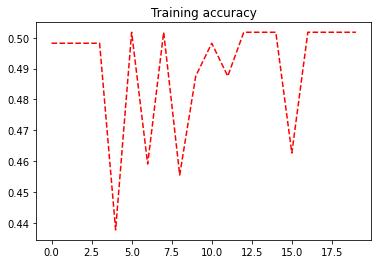

Testing:
[[34  2]
 [30  5]]
Precision:  0.7142857142857143
Recall:  0.14285714285714285
F1 score:  0.23809523809523808
Mean accuracy:  0.5492957746478874
AUC:  0.5436507936507936
mcc:  0.14640921281248623
kappa:  0.0882825040128411
['lixao', 'naolixao']


In [23]:
#load or train main experiment (mines an dams discovery)
print("Discovery model:")
main_model,main_labels,image_width,image_height,nmean,nmax = model_workflow(path_to_output, path_to_images, 0)
print(main_labels)


In [ ]:
# ore type classifier
#if oretypeclassifier is not None:  #check if ore classifier is required
#  print("Ore classifier :")
#  ore_classifier,ore_labels,_,_,_,_ = model_workflow(path_to_oretype_output, path_to_oretype_samples, 1,main_model,nmean,nmax)
#  print(ore_labels)
#else:
ore_classifier = None

print("Model loaded. Options: (1: run model on images of prediction folder 2: Show models metrics 3: exit")
try:
  x=int(input('Input:'))
except ValueError:
  print("Not a number")

if x==1:
  # use model to predict
  if os.path.exists(path_to_predict_images):
    x = len(os.listdir(path_to_predict_images))
    if x== 0:
      print("No images found on the prediction folder")
    else:  
      print(x,"images found on the prediction folder. How many do you want to use?(-1 for all of them)")
      try:
        n=int(input('Input:'))
      except ValueError:
        print("Not a number")

      print("Choose a slicing factor (use 1 for images up to 1GB, will break the TIFF in n^2 pieces)")
      try:
        slicing=int(input('Input:'))
      except ValueError:
        print("Not a number")

      predict(main_model,ore_classifier,n,main_labels,ore_labels,image_width,image_height,nmean,nmax,N_BANDS,slicing)

  else:
    print("Folder containing images for prediction not found ",path_to_predict_images)
elif x==2:
  print("Main model metrics:")
  show_model_metrics(path_to_output)
  print("Ore type model metrics:")
  show_model_metrics(path_to_oretype_output)